<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install transformers

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
from datasets import Dataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else device
device

'cuda'

In [ ]:
df = pd.read_excel('data_problems.xlsx', index_col=0)
df = df.rename(columns={'Задача': 'text', 'Тема': 'topic'})
df


,text,topic
0,Между девятью планетами Солнечной системы введ...,Графы
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы
2,"В государстве 100 городов, и из каждого из них...",Графы
3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы
4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы
...,...,...
1,Дьявол предлагает Человеку сыграть в следующую...,Дирихле
2,По шоссе в одном направлении едут 10 автомобил...,Дирихле
0,В пространстве имеются 30 ненулевых векторов. ...,Дирихле
1,На плоскости даны две точки A и B. Пусть C – н...,Дирихле


In [ ]:
df['topic'].value_counts()


topic
Теория чисел     2396
Комбинаторика    1020
Дирихле           441
Многочлен         426
Графы             384
Геометрия         371
Инвариант         235
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(df['topic'].values)
df['label'] = labels
df

,text,topic,label
0,Между девятью планетами Солнечной системы введ...,Графы,1
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы,1
2,"В государстве 100 городов, и из каждого из них...",Графы,1
3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы,1
4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы,1
...,...,...,...
1,Дьявол предлагает Человеку сыграть в следующую...,Дирихле,2
2,По шоссе в одном направлении едут 10 автомобил...,Дирихле,2
0,В пространстве имеются 30 ненулевых векторов. ...,Дирихле,2
1,На плоскости даны две точки A и B. Пусть C – н...,Дирихле,2


In [ ]:
dataset = Dataset.from_pandas(df[['text', 'label']],  preserve_index=False)
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4745
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 528
    })
})

In [ ]:
train_y = torch.LongTensor(dataset['train']['label'])
test_y = torch.LongTensor(dataset['test']['label'])

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)



In [ ]:
from transformers import AutoConfig, AutoModel

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_classes: int):
        super(TransformerClassificationModel, self).__init__()
        config = AutoConfig.from_pretrained(base_transformer_model)
        config.output_attentions = True

        self.backbone = AutoModel.from_pretrained(base_transformer_model, config=config)

        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        probabilities = self.softmax(logits)
        return {'logits': logits, 'probabilities': probabilities, 'backbone outputs': outputs,}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel, freeze=True):
    for param in model.backbone.parameters():
        param.requires_grad = not freeze
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
import copy

def train_transformer(transformer_model, dataset, num_epochs=3, freeze_backbone=True):
    model = copy.deepcopy(transformer_model)

    model = freeze_backbone_function(model, freeze_backbone)
    model.to(device)

    training_args = TrainingArguments(
        output_dir="result",
        learning_rate=2e-5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],

    )
    trainer.train()
    return model


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import copy


class TransformerClassificationTrainer:
    def __init__(self, model, tokenizer, max_length=256, batch_size=32, lr=2e-4, num_epochs=3, freeze_backbone=False):
        self.model = freeze_backbone_function(model, freeze_backbone)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs

    def preprocess_data(self, texts, labels):
        inputs = self.tokenizer(texts, padding=True, truncation=True, max_length=self.max_length, return_tensors="pt")
        labels = torch.tensor(labels)
        return inputs, labels

    def train(self, train_texts, train_labels):
        train_inputs, train_labels = self.preprocess_data(train_texts, train_labels)
        train_data = torch.utils.data.TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        optimizer = AdamW(self.model.parameters(), lr=self.lr)
        loss_fn = nn.CrossEntropyLoss()

        self.model.to(device)
        self.model.train()

        for epoch in range(self.num_epochs):
            total_loss = 0
            for batch in train_loader:
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, labels = batch

                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)
                logits = outputs['logits']
                loss = loss_fn(logits, labels)
                total_loss += loss.item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

            avg_train_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss:.4f}")

        return self.model



    def evaluate(self, test_texts, test_labels):
        self.model.eval()
        test_inputs, test_labels = self.preprocess_data(test_texts, test_labels)
        test_data = torch.utils.data.TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in test_loader:
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, labels = batch
                outputs = self.model(input_ids, attention_mask)
                logits = outputs['logits']
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(true_labels, predictions)
        print(f"Accuracy: {accuracy:.4f}")
        f1 = f1_score(true_labels, predictions, average='macro')
        print(f"F1 score: {f1:.4f}")




### Задание 4 (1 балл)


Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
rt2_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()

In [ ]:
rt2 = TransformerClassificationModel("cointegrated/rubert-tiny2", num_classes=7)

rt2_trainer = TransformerClassificationTrainer(model=rt2,
                                               tokenizer=rt2_tokenizer,
                                               freeze_backbone=False,
                                               num_epochs=15)

rt2_trained = rt2_trainer.train(dataset['train']['text'], dataset['train']['label'])
rt2_trainer.evaluate(dataset['test']['text'], dataset['test']['label'])

Epoch 1/15, Train Loss: 1.1428
Epoch 2/15, Train Loss: 0.8280
Epoch 3/15, Train Loss: 0.6650
Epoch 4/15, Train Loss: 0.5646
Epoch 5/15, Train Loss: 0.4968
Epoch 6/15, Train Loss: 0.4577
Epoch 7/15, Train Loss: 0.4189
Epoch 8/15, Train Loss: 0.3928
Epoch 9/15, Train Loss: 0.3704
Epoch 10/15, Train Loss: 0.3552
Epoch 11/15, Train Loss: 0.3372
Epoch 12/15, Train Loss: 0.3338
Epoch 13/15, Train Loss: 0.3215
Epoch 14/15, Train Loss: 0.3142
Epoch 15/15, Train Loss: 0.3112
Accuracy: 0.6004
F1 score: 0.4971


In [ ]:
rt2_freeze = TransformerClassificationModel("cointegrated/rubert-tiny2", num_classes=7)

rt2_freeze_trainer = TransformerClassificationTrainer(model=rt2_freeze,
                                                      tokenizer=rt2_tokenizer,
                                                      freeze_backbone=True,
                                                      num_epochs=15)

rt2_freeze_trained = rt2_freeze_trainer.train(dataset['train']['text'], dataset['train']['label'])
rt2_freeze_trainer.evaluate(dataset['test']['text'], dataset['test']['label'])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15, Train Loss: 1.7874
Epoch 2/15, Train Loss: 1.6005
Epoch 3/15, Train Loss: 1.5170
Epoch 4/15, Train Loss: 1.4690
Epoch 5/15, Train Loss: 1.4275
Epoch 6/15, Train Loss: 1.3961
Epoch 7/15, Train Loss: 1.3678
Epoch 8/15, Train Loss: 1.3454
Epoch 9/15, Train Loss: 1.3266
Epoch 10/15, Train Loss: 1.3103
Epoch 11/15, Train Loss: 1.2882
Epoch 12/15, Train Loss: 1.2745
Epoch 13/15, Train Loss: 1.2598
Epoch 14/15, Train Loss: 1.2504
Epoch 15/15, Train Loss: 1.2370
Accuracy: 0.5720
F1 score: 0.3387


### Задание 5 (1 балл)
Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
mathBert_tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBert")

In [ ]:
mathBert = TransformerClassificationModel("tbs17/MathBert", num_classes=7)

mathBert_trainer = TransformerClassificationTrainer(model=mathBert,
                                                    tokenizer=mathBert_tokenizer,
                                                    freeze_backbone=False,
                                                    num_epochs=15,
                                                    max_length = 64)

mathBert_trained = mathBert_trainer.train(dataset['train']['text'], dataset['train']['label'])
mathBert_trainer.evaluate(dataset['test']['text'], dataset['test']['label'])

Epoch 1/15, Train Loss: 1.6938
Epoch 2/15, Train Loss: 1.6309
Epoch 3/15, Train Loss: 1.6298
Epoch 4/15, Train Loss: 1.6305
Epoch 5/15, Train Loss: 1.6282
Epoch 6/15, Train Loss: 1.6259
Epoch 7/15, Train Loss: 1.6274
Epoch 8/15, Train Loss: 1.6214
Epoch 9/15, Train Loss: 1.6259
Epoch 10/15, Train Loss: 1.6226
Epoch 11/15, Train Loss: 1.6263
Epoch 12/15, Train Loss: 1.6285
Epoch 13/15, Train Loss: 1.6281
Epoch 14/15, Train Loss: 1.6284
Epoch 15/15, Train Loss: 1.6266
Accuracy: 0.5019
F1 score: 0.0955


In [ ]:
mathBert_freeze = TransformerClassificationModel("tbs17/MathBert", num_classes=7)

mathBert_freeze_trainer = TransformerClassificationTrainer(model=mathBert_freeze,
                                                           tokenizer=mathBert_tokenizer,
                                                           freeze_backbone=True,
                                                           num_epochs=15,
                                                           max_length = 64)

mathBert_freeze_trained = mathBert_freeze_trainer.train(dataset['train']['text'], dataset['train']['label'])
mathBert_freeze_trainer.evaluate(dataset['test']['text'], dataset['test']['label'])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15, Train Loss: 1.6234
Epoch 2/15, Train Loss: 1.5869
Epoch 3/15, Train Loss: 1.5682
Epoch 4/15, Train Loss: 1.5535
Epoch 5/15, Train Loss: 1.5431
Epoch 6/15, Train Loss: 1.5226
Epoch 7/15, Train Loss: 1.5185
Epoch 8/15, Train Loss: 1.5041
Epoch 9/15, Train Loss: 1.4958
Epoch 10/15, Train Loss: 1.4815
Epoch 11/15, Train Loss: 1.4761
Epoch 12/15, Train Loss: 1.4727
Epoch 13/15, Train Loss: 1.4618
Epoch 14/15, Train Loss: 1.4543
Epoch 15/15, Train Loss: 1.4496
Accuracy: 0.5114
F1 score: 0.1870


Со второй моделью все получилось намного хуже. Изначально она обучена на математических текстах на английском языке. Токенизатор модели раскладывает русский текст по отдельным буквам. С учетом эотго модель получается более сложная и для ее обучения нужно большее количество ресурсов. С учетом возможностей коллаба, в работе модель обладает максимальными параметрами, чтобы не превратить процесс обучения в пытку старением)))

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_first_layer_attention_maps(model, tokenizer, text, model_name='Model'):
    model.to('cpu')
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    attentions = outputs['backbone outputs']['attentions'][0][0][0]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(attentions.detach().numpy(),
                cmap='viridis', ax=ax,
                xticklabels=tokens, yticklabels=tokens)

    ax.set_title(f'{model_name}: layer 1 Attention Map')
    ax.set_xlabel('Token')
    ax.set_ylabel('Token')
    plt.show()

In [ ]:
text_for_map = "Текст для проверки функции отрисовки карты внимания модели."

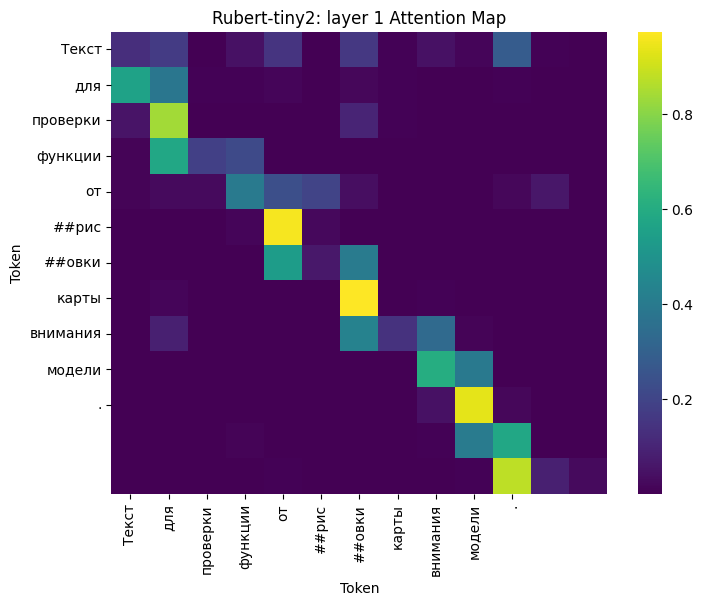

In [ ]:
draw_first_layer_attention_maps(rt2_trained,
                                rt2_tokenizer,
                                text_for_map,
                                "Rubert-tiny2")

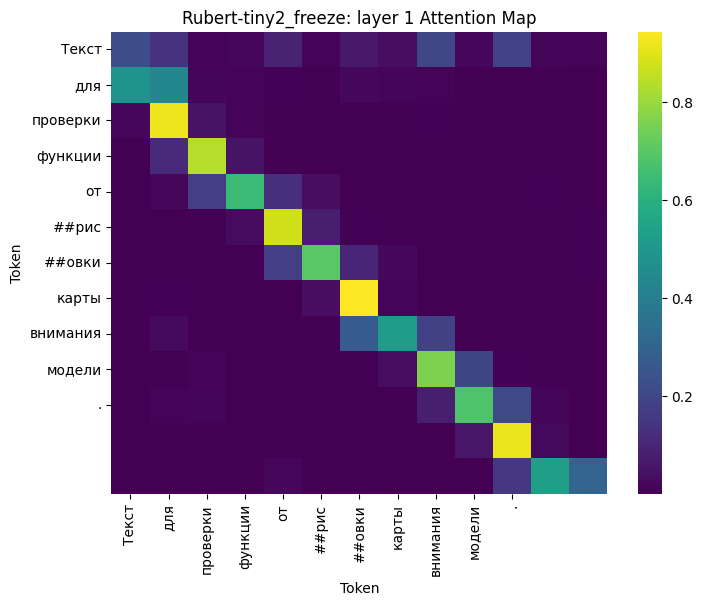

In [ ]:
draw_first_layer_attention_maps(rt2_freeze_trained,
                                rt2_tokenizer,
                                text_for_map,
                                "Rubert-tiny2_freeze")

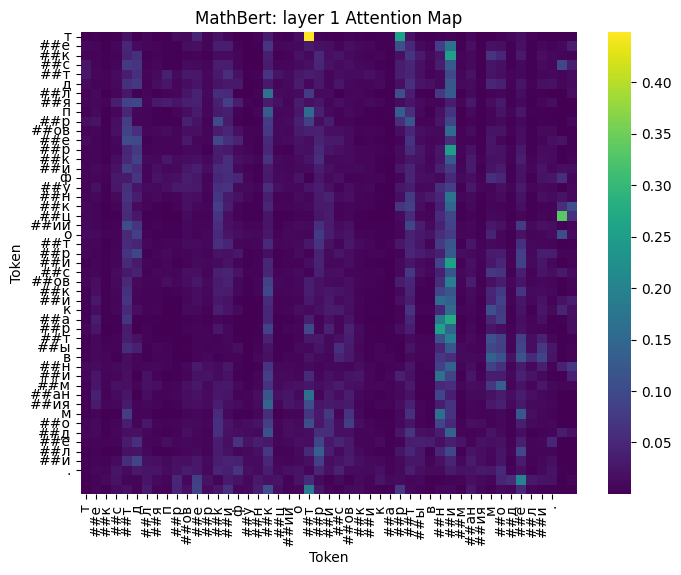

In [ ]:
draw_first_layer_attention_maps(mathBert_trained,
                                mathBert_tokenizer,
                                text_for_map,
                                "MathBert")

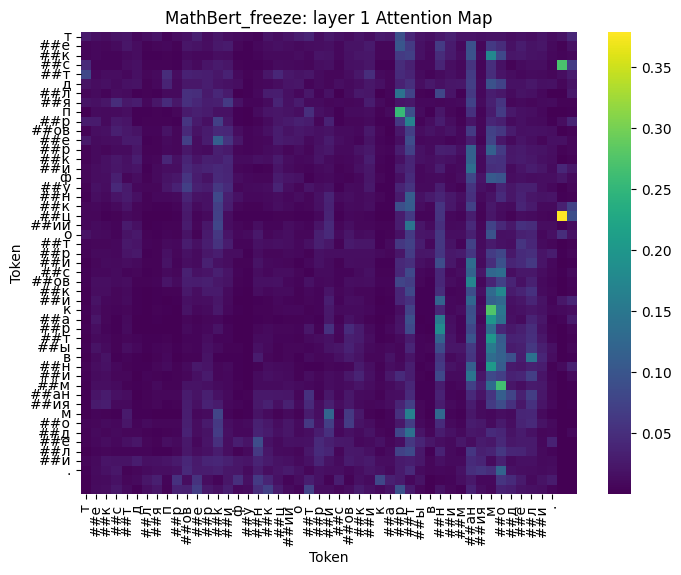

In [ ]:
draw_first_layer_attention_maps(mathBert_freeze_trained,
                                mathBert_tokenizer,
                                text_for_map,
                                'MathBert_freeze')

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

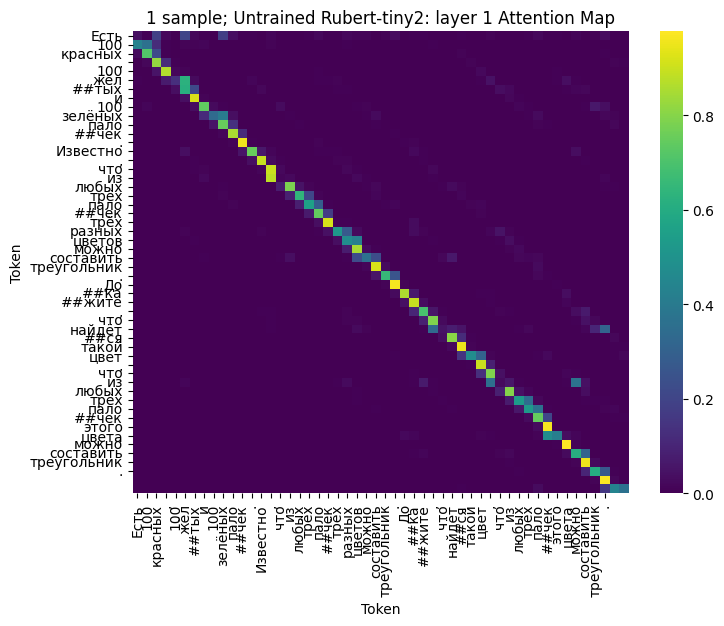

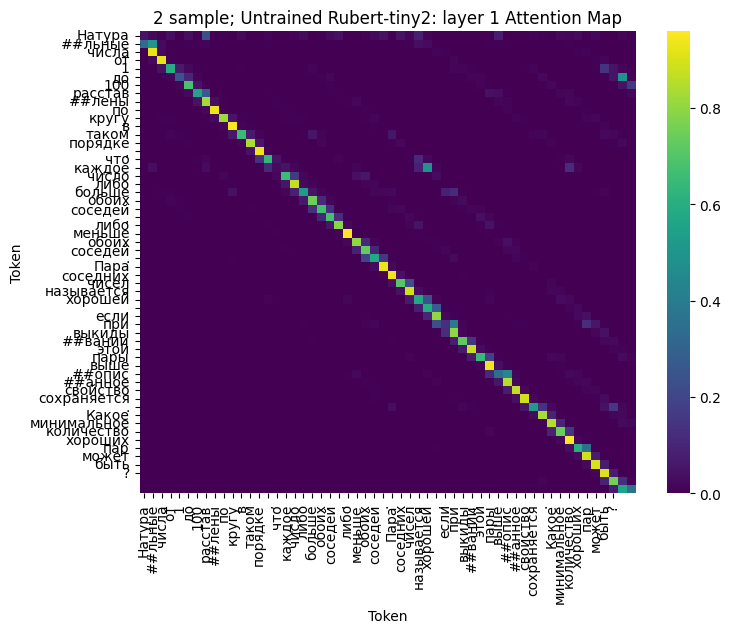

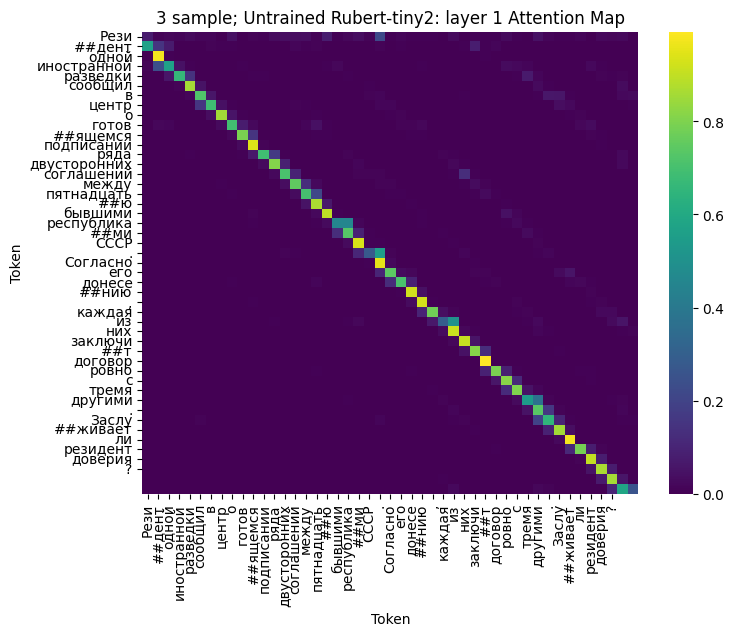

In [ ]:
untrained_rt2 = TransformerClassificationModel("cointegrated/rubert-tiny2",
                                               num_classes=7)
for i in range(3):
  draw_first_layer_attention_maps(untrained_rt2,
                                  rt2_tokenizer,
                                  dataset['test']['text'][i],
                                  f'{i+1} sample; Untrained Rubert-tiny2')


Новая необученная модель rubert-tiny побольшому счету улавливает только связи на главной диагонали. Каких ко связей вне ее на картинках мы не наблюдаем.

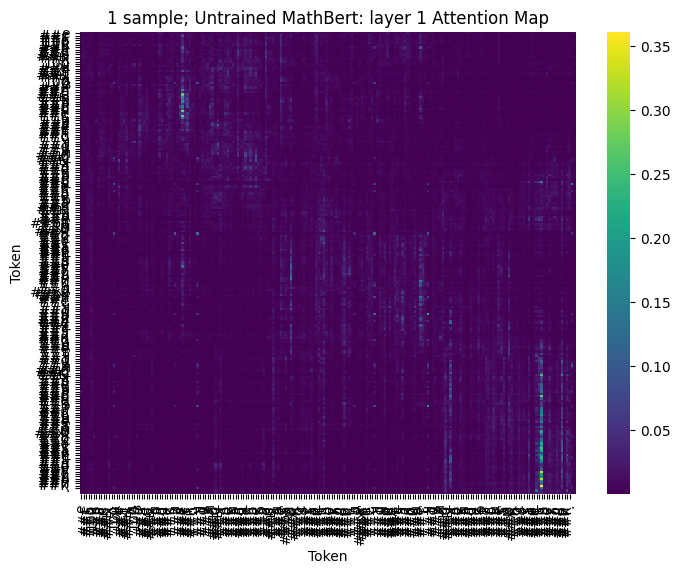

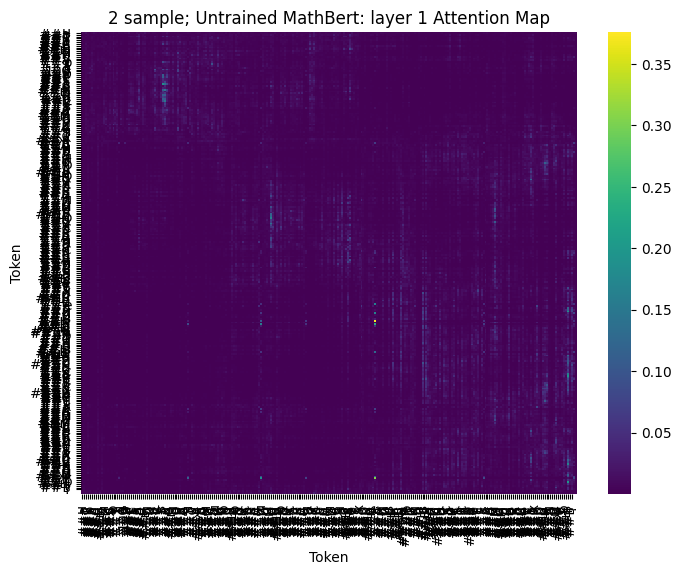

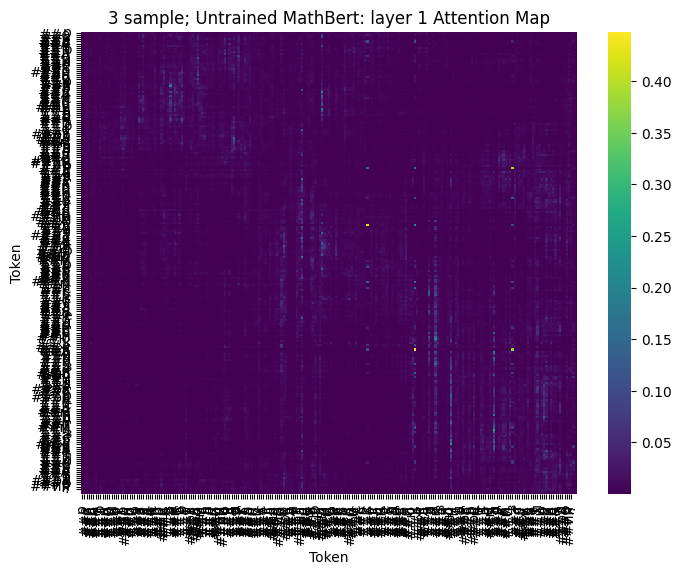

In [ ]:
untrained_mathBert = TransformerClassificationModel("tbs17/MathBert", num_classes=7)
for i in range(3):
  draw_first_layer_attention_maps(untrained_mathBert,
                                  mathBert_tokenizer,
                                  dataset['test']['text'][i],
                                  f'{i+1} sample; Untrained MathBert')


MathBert изнычально обучена на английских текстах. Текст на русском языке токенизатор разбивает практически по буквам, соответственно, на русском языке модель практически не обучается.  Что касается отрисовки карты внимания, мы видим, что внимание модели уже нинкак не состредоточено на главной диагонали, а разбросано по всему набору токенов.

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

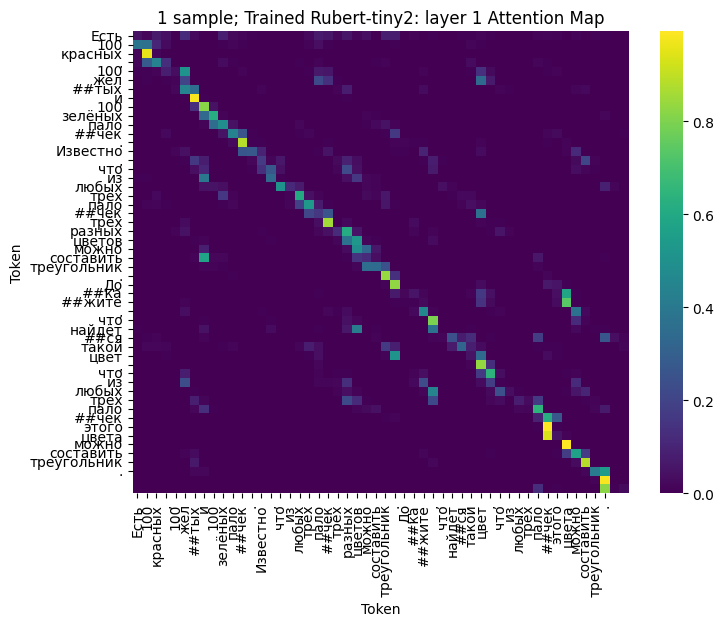

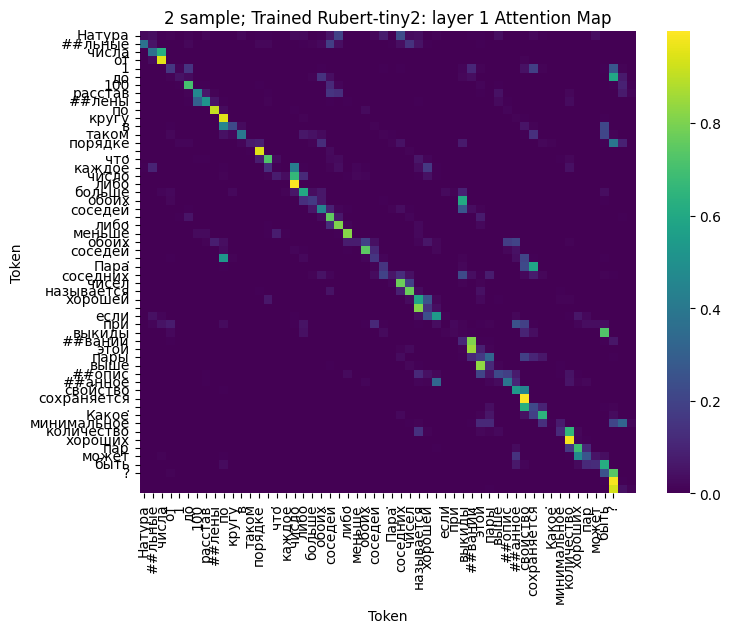

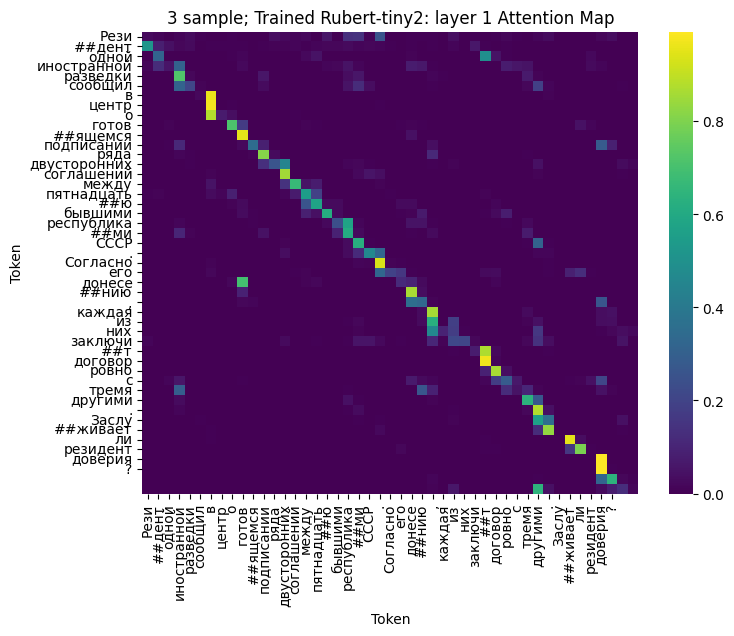

In [ ]:
for i in range(3):
  draw_first_layer_attention_maps(rt2_trained,
                                  rt2_tokenizer,
                                  dataset['test']['text'][i],
                                  f'{i+1} sample; Trained Rubert-tiny2')

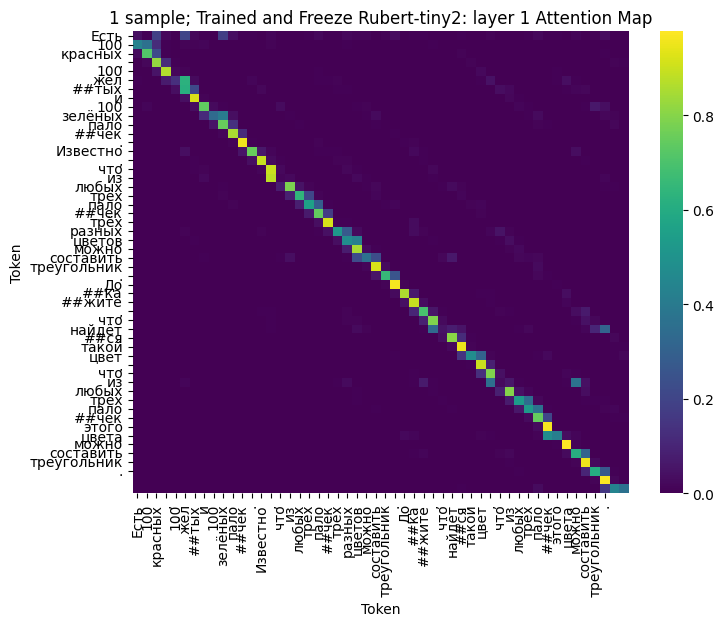

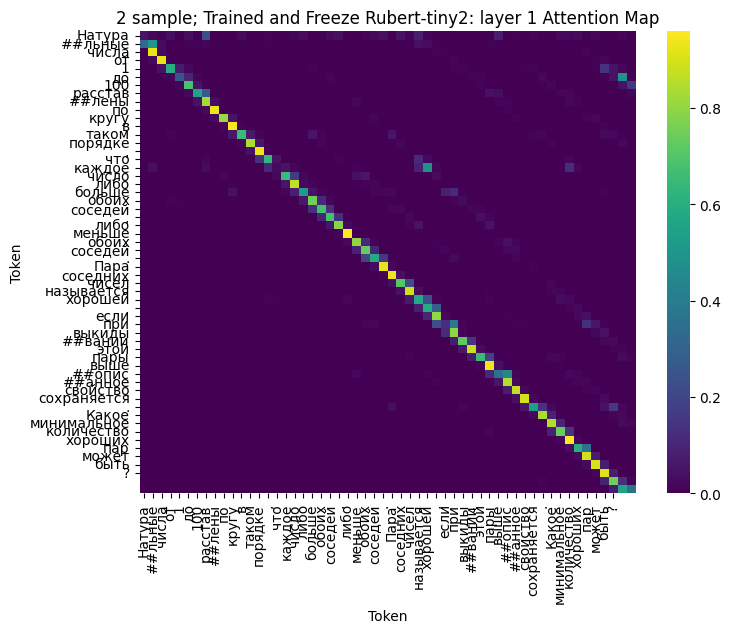

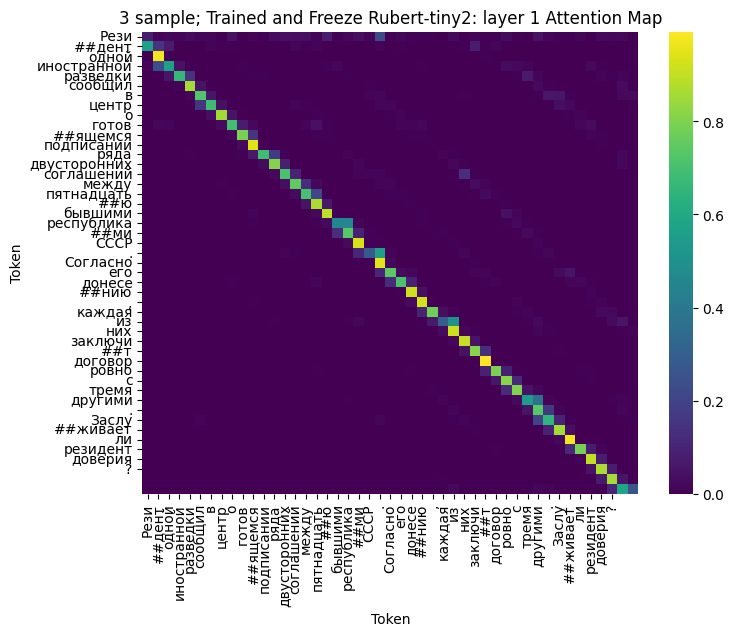

In [ ]:
for i in range(3):
  draw_first_layer_attention_maps(rt2_freeze_trained,
                                  rt2_tokenizer,
                                  dataset['test']['text'][i],
                                  f'{i+1} sample; Trained and Freeze Rubert-tiny2')

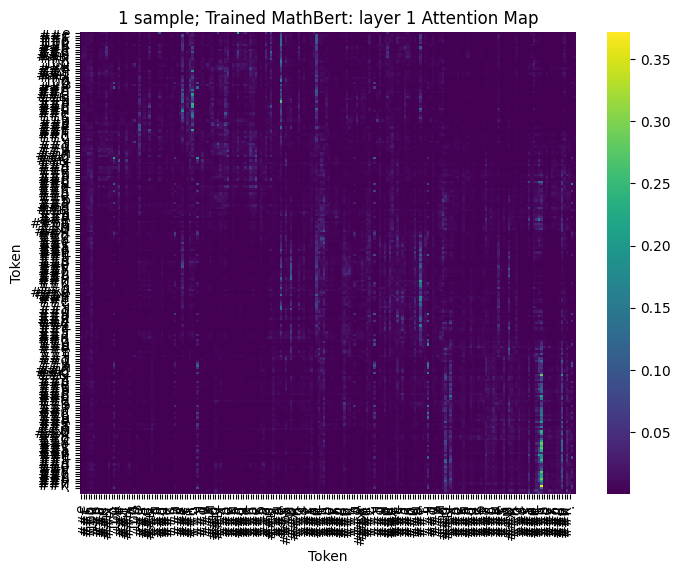

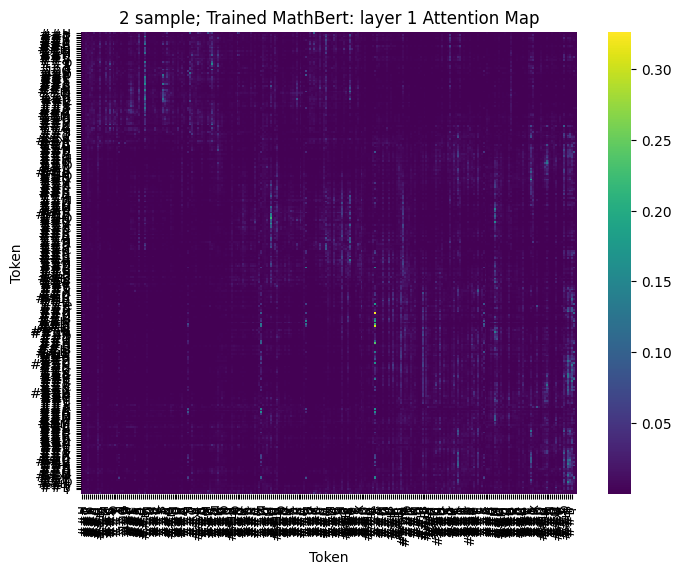

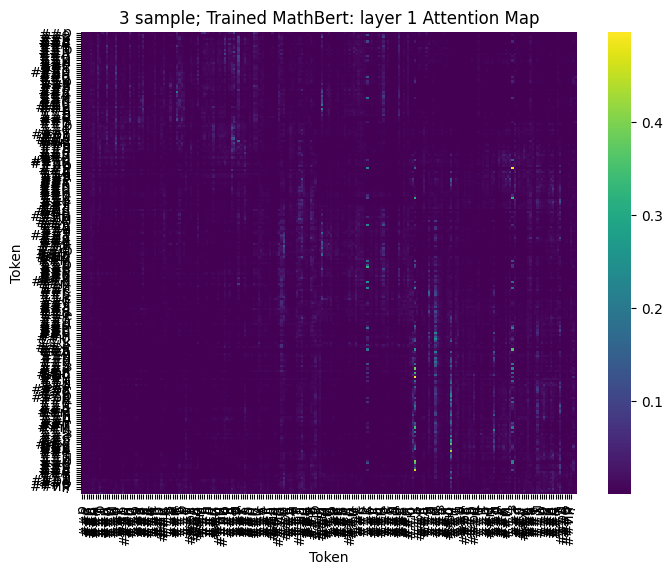

In [ ]:
for i in range(3):
  draw_first_layer_attention_maps(mathBert_trained,
                                  mathBert_tokenizer,
                                  dataset['test']['text'][i],
                                  f'{i+1} sample; Trained MathBert')

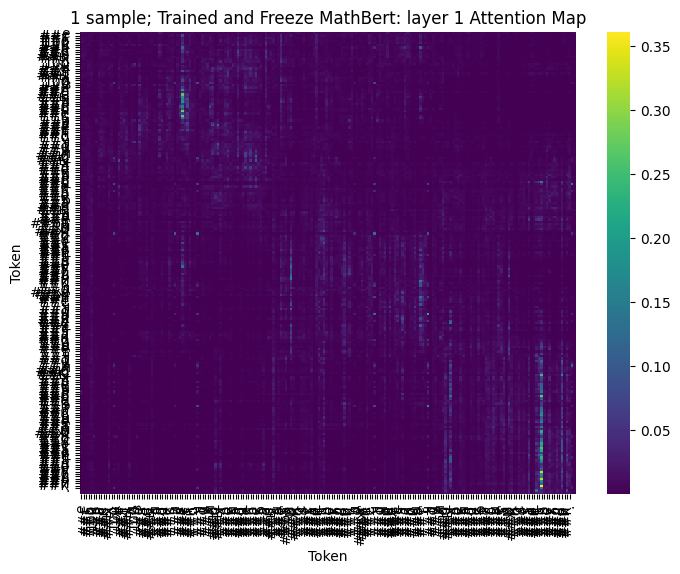

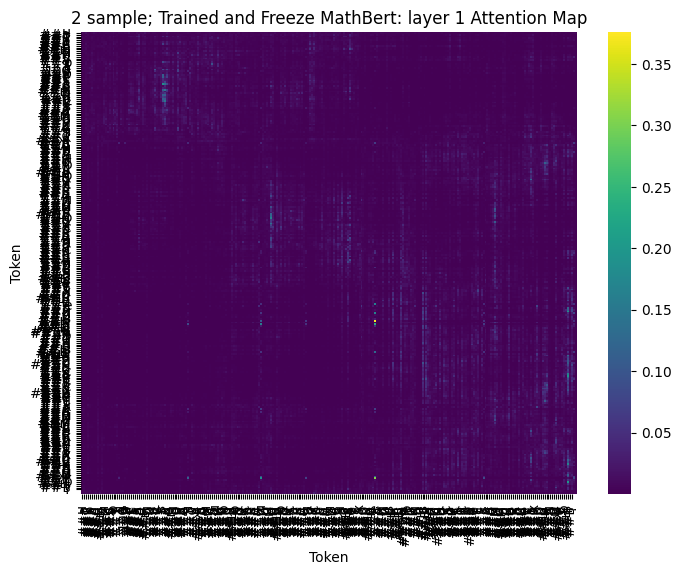

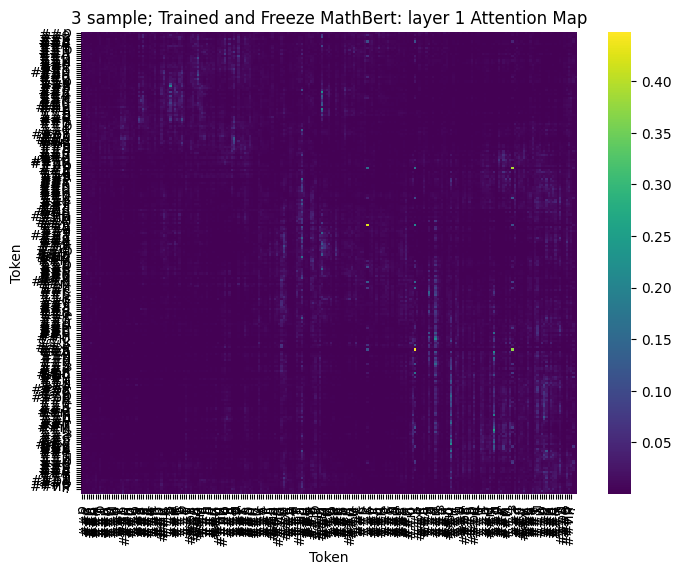

In [ ]:
for i in range(3):
  draw_first_layer_attention_maps(mathBert_freeze_trained,
                                  mathBert_tokenizer,
                                  dataset['test']['text'][i],
                                  f'{i+1} sample; Trained and Freeze MathBert')

Мы видим, что после дообучения моделей карты внимания сталь более сложными. Модели начали улавливать какие-то зависимости между словами и их порядком. Лучше всего себя показывают модели, которые обучались полностью без заморозки слоев.
